# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

## CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

---
### Data Mining Goals and KPIs ("_The Data Problem Definition_")

Utilize statistical approaches to sanitize and/or impute any feature (independent variable) values within the dataset to understand correlations and collinearity of used car features to independently predict the target feature, sale price. From this understanding, only retain features that demonstrate reasonable correlations, and engineer any relevant features that may enrich the dataset when modeling.  

From this new prepared dataset, train a few regression model estimators to determine which may most reasonably predict out-of-sample sale prices based on known key car features. Each model's hyperparameters will be optimized for it's best performance, where the model with the lowest prediction error will be considered the best estimator.

The best estimator's coefficients/algorithm will eventually become a testing tool provided to our client (_Fast Ameet's Used Car Emporium_) to guide future used car inventory to optimize minimize the time a car sits in their car lot (ROI).

---

## Notebook Setup
* Imported Python libraries and methods
* General configurations

### Python Libraries and Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#----------------------#
#--- Understanding ----#
#----------------------#



#--------------------#
#--- Preparation ----#
#--------------------#

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

#-----------------#
#--- Modeling ----#
#-----------------#

from sklearn.linear_model import LinearRegression, Ridge, Lasso

#-------------------#
#--- Optimizing ----#
#-------------------#

from sklearn.model_selection import GridSearchCV

#-------------------#
#--- Evaluating ----#
#-------------------#

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

#-----------------------#
#--- Configurations ----#
#-----------------------#
# Library to improve printed tabular data readability
%pip install tabulate
from tabulate import tabulate

import warnings

print("All files loaded")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
All files loaded


### Environment Configurations

In [2]:
# Default plot figure sizes
plt.rcParams["figure.figsize"] = (16, 5)

# Pipeline configuration visualization
from sklearn import set_config
set_config(display="diagram")

# Silence any warnings
#warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.4f' % x)


### Load the Dataset

In [3]:
df = pd.read_csv("data/vehicles.csv")

# retain a copy of the original dataset
original_df = df.copy()
original_shape = original_df.shape

df.shape, original_shape

((426880, 18), (426880, 18))

### Custom Python Functions

In [4]:
def helper_print_heading ( heading, length = 120 ):
    '''
    Purpose: Uniform means to add a heading to printed information
    Inputs:
    - heading: string to use for heading, uppercased by default
    - length: override overall width consumed by title and dashes
    '''
    padding = int(( length - len(heading) - 6 ) / 2 )
    return '\n/' + ('─' * padding) + f'  {heading.upper()}  ' + ('─' * padding) + "/\n"

def check_sequence( test_number ):
    '''
    Purpose: Identify "unrealistic" car prices to exclude from the modeling
    Function: Evalute a number's value, hypothesizing it's "unrealistic" if it's:
    - below a threshold (100)
    - digits in sequence (ascending or descending order)
    - single digit repeating
    - above a threshold (> 5MM)
            
    Inputs:
    - test_number: number who's value will be tested for the above stated conditions:
    '''
    
    # Initialize return variable, start by presuming the number if "good"
    is_fake = False
    
    lower_bound = 100
    upper_bound = 5000000
    
    test_number_str = str( test_number )
    first_digit = int ( test_number_str[0] )
    last_digit = int ( test_number_str[-1] )
    
    # Check if the value is below threshold
    if int( test_number ) < lower_bound:
        #is_fake = True
        return "low"
        
    # Check if the value is a sequence
    if test_number_str == ''.join( str( i ) for i in range( first_digit, last_digit + 1 )):
        #is_fake = True
        return "sequence (asc)"
    
    if test_number_str == ''.join( str( i ) for i in range( first_digit, last_digit - 1, -1 )):
        #is_fake = True
        return "sequence (desc)"

    # Check if the value is repeating
    if len( set( test_number_str )) == 1:
        #is_fake = True
        return "repeating"
    
    # Check if the value is above the `upper_bound`
    if int( test_number_str ) > upper_bound:
        #is_fake = True
        return "high"
    
    #return is_fake
    return "valid"


## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

---

### Exploring the Dataset (EDA)
* Review data integrity (missing values or duplicated records) to inform decisions to either impute or drop null data values from the dataset.
* Understand each feature's value sets and data type to determine if any type changes or feature engineering will be beneficial.
* Generate a correlation matrix to understand if any features demonstrate multicollinearity and should be omitted from the prepared dataset to model against.
* Generate plots as relevant to understand how different feature values may impact sale pricing.

---

### Data Integrity Review

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [6]:
df.describe([.1, .2, .85, .95, .99]) 
# data will need to be scaled/normalized

,id,price,year,odometer
count,426880.0000,426880.0000,425675.0000,422480.0000
mean,7311486634.2243,75199.0332,2011.2352,98043.3314
std,4473170.4126,12182282.1736,9.4521,213881.5008
min,7207408119.0000,0.0000,1900.0000,0.0000
10%,7304399132.1000,500.0000,2003.0000,14939.0000
20%,7307115339.2000,4500.0000,2007.0000,30000.0000
50%,7312620821.0000,13950.0000,2013.0000,85548.0000
85%,7316138455.1500,32995.0000,2018.0000,159628.7500
95%,7316743266.1000,44500.0000,2020.0000,204000.0000
99%,7316955976.4200,66995.0000,2020.0000,280000.0000



/─────────────────────────────────────────  TOTAL MISSING VALUES BY FEATURE  ─────────────────────────────────────────/
 |              |   Missing Values |   Percentage |
|--------------+------------------+--------------|
| size         |           306361 |       71.767 |
| cylinders    |           177678 |       41.622 |
| condition    |           174104 |       40.785 |
| VIN          |           161042 |       37.725 |
| drive        |           130567 |       30.586 |
| paint_color  |           130203 |       30.501 |
| type         |            92858 |       21.753 |
| manufacturer |            17646 |        4.134 |
| title_status |             8242 |        1.931 |
| model        |             5277 |        1.236 |
| odometer     |             4400 |        1.031 |
| fuel         |             3013 |        0.706 |
| transmission |             2556 |        0.599 |
| year         |             1205 |        0.282 |
| id           |                0 |        0     |
| region   

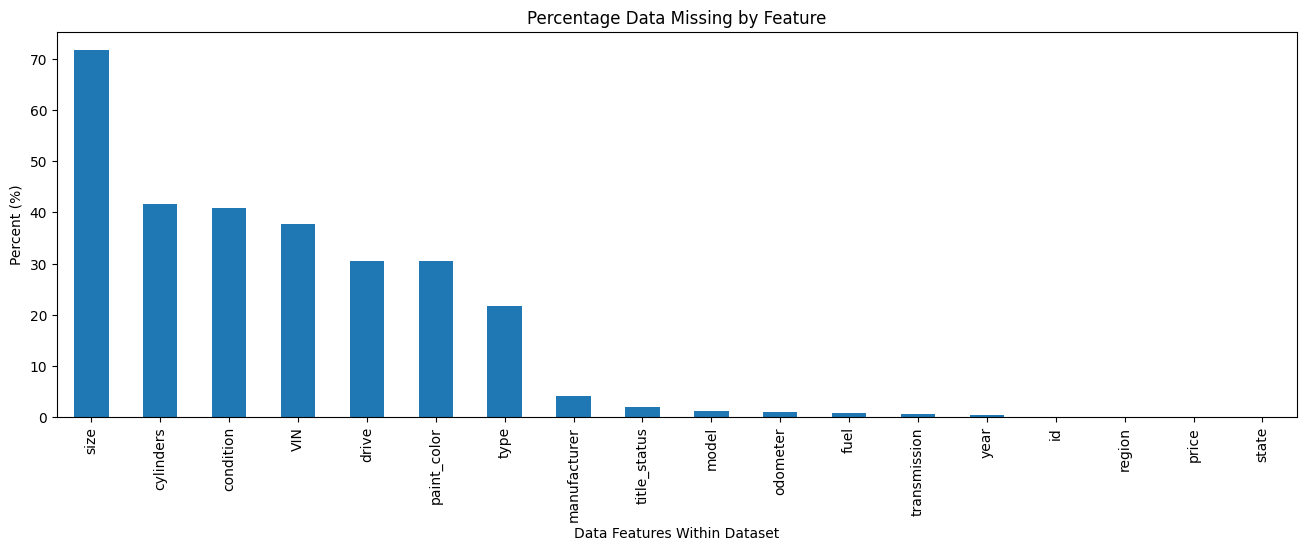

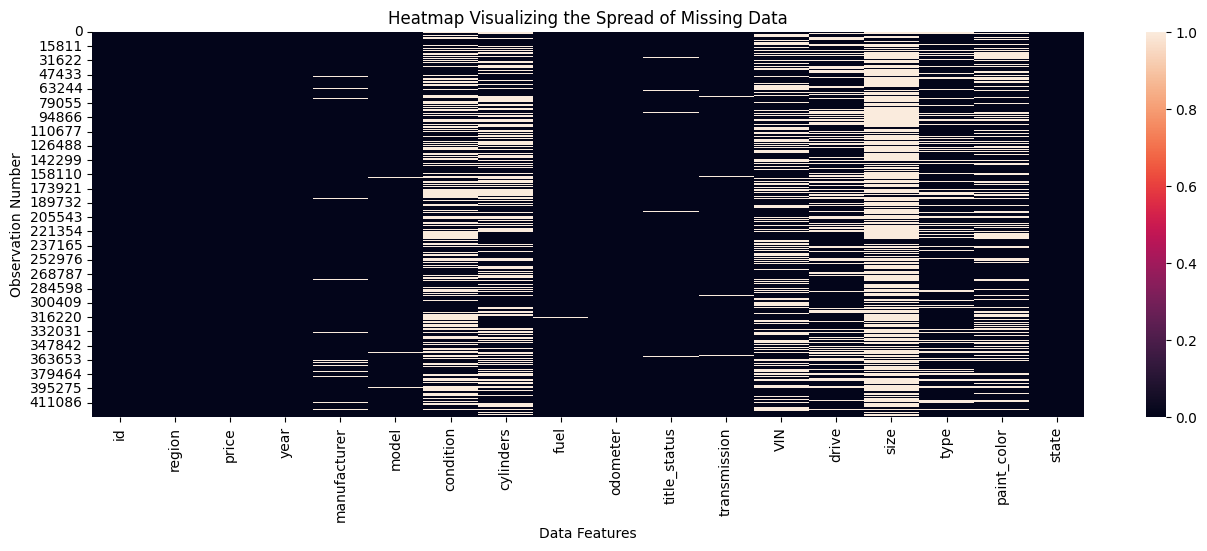

In [7]:
'''
Review missing values and duplicated records:
- tabular view to understand missing data by feature
- heatmap view to understand distribution of missing data

* good candidate for a reusable custom function (pass in DataFrame), leaving inline for class grading / inline readability
'''

df_missing_sum = df.isna().sum()
df_missing_perc = round(df.isna().mean()*100, 3)
df_integrity = pd.DataFrame( { "Missing Values": df_missing_sum, 
                              "Percentage": df_missing_perc }
                           ).sort_values("Percentage", ascending=False)

print( helper_print_heading( 'Total Missing Values by Feature' ), tabulate( df_integrity, headers=df_integrity.columns, tablefmt="orgtbl" ), 
       "\n\n",
       helper_print_heading( 'Number of Duplicated Records in Dataset' ), f"{df.duplicated().sum()} records duplicated" 
    )

df_integrity["Percentage"].plot(kind="bar", title="Percentage Data Missing by Feature")
plt.ylabel("Percent (%)")
plt.xlabel("Data Features Within Dataset")
plt.show()

# Let's visually evaluate the missing data across any data feature to understand distribution, 
# for any additional insights
sns.heatmap(df.isna()).set_title("Heatmap Visualizing the Spread of Missing Data")
plt.xlabel("Data Features")
plt.ylabel("Observation Number")
plt.show()


---
#### Observations:
* Quite a lot of missing values within this dataset.
* A review of individual features and their potential modeling value is needed before addressing missing values.
* Selected numerical features will require standardization before modeling.
---

### Review Each Feature for Potential Usefulness

Take a cursory review of each feature's data type and values to understand which may be important, and which can be dropped.

In [8]:
'''
Establish lists for categorical and numberical features for future transformations
- Drop the noisy/largely unique features so plots are useful
'''
cols_df = df.drop(["id", "VIN", "region", "state", "model"], axis=1)
cols_categorical = cols_df.select_dtypes(include=["object"]).columns.tolist()
cols_numerical = cols_df.select_dtypes(exclude=["object"]).columns.tolist()
cols_categorical, cols_numerical

(['manufacturer',
  'condition',
  'cylinders',
  'fuel',
  'title_status',
  'transmission',
  'drive',
  'size',
  'type',
  'paint_color'],
 ['price', 'year', 'odometer'])

In [9]:
df["model"].value_counts(normalize=True) * 100
# too many unique values; may consider a laborious sanitization to make the values more uniform and potentially useful, 
# but let's drop the feature for current modeling exercise.

model
f-150                     1.8997
silverado 1500            1.2192
1500                      0.9988
camry                     0.7436
silverado                 0.7170
                           ...  
plymouth fury 1           0.0002
f550 box truck delivery   0.0002
duramax 2500hd            0.0002
3 s sport                 0.0002
Paige Glenbrook Touring   0.0002
Name: proportion, Length: 29649, dtype: float64

In [10]:
df["year"].value_counts(normalize=True) * 100
# Use `year` if a distribution, or convert to `age` (2023 - `year`)

year
2017.0000   8.5558
2018.0000   8.5438
2015.0000   7.4089
2013.0000   7.2342
2016.0000   7.1496
             ...  
1943.0000   0.0002
1915.0000   0.0002
1902.0000   0.0002
1905.0000   0.0002
1909.0000   0.0002
Name: proportion, Length: 114, dtype: float64

#### Explore "id" Feature

In [11]:
print(tabulate( pd.DataFrame(df["id"].value_counts( dropna=False ).sort_values( ascending=False ).head()), headers=["Count"], tablefmt="orgtbl" ))
# There may be some value in computing distance between IDs in some grouped datasets, but for now, dropping this feature.

|            |   Count |
|------------+---------|
| 7222695916 |       1 |
| 7314589649 |       1 |
| 7222270760 |       1 |
| 7210384030 |       1 |
| 7222379453 |       1 |


#### Explore "VIN" Feature

In [12]:
df["VIN"].value_counts( dropna=False, normalize=True ).sort_values( ascending=False ).head()


VIN
NaN                 0.3773
1FMJU1JT1HEA52352   0.0006
3C6JR6DT3KG560649   0.0006
1FTER1EH1LLA36301   0.0005
5TFTX4CN3EX042751   0.0005
Name: proportion, dtype: float64

**Investigate:** `VIN` column should represent a unique Vehicle ID, explore one vehicle ID to see if it's multple sales of the same vehicle, or just listed multiple locations for sale

In [13]:
df.query("VIN == '3C6JR6DT3KG560649'").sample(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
419334,7311948316,la crosse,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
216784,7313349138,rochester,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,mn
418145,7313336845,janesville,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
418569,7313325188,kenosha-racine,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
301252,7313394610,sandusky,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,oh
155356,7313362227,terre haute,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,in
284549,7313481982,new hampshire,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,nh
219735,7311986578,columbia / jeff city,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,mo
302051,7311878351,toledo,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,oh
417423,7311854428,green bay,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi


In [14]:
df.query("VIN == '3C6JR6DT3KG560649'").duplicated().sum()

0

In [15]:
df.drop(["region", "state"], axis=1).query("VIN == '3C6JR6DT3KG560649'").duplicated().sum()

0

#### Univariate Analysis
Explore each categorical and numerical feature to understand each feature's values, and potential options to address missing values


/──────────────────────────────────────────────  FEATURE: MANUFACTURER  ──────────────────────────────────────────────/
 |    | Value           |       Count |
|----+-----------------+-------------|
|  0 | ford            | 0.166288    |
|  1 | chevrolet       | 0.128992    |
|  2 | toyota          | 0.0801209   |
|  3 | honda           | 0.0498243   |
|  4 | nissan          | 0.0446659   |
|  5 | jeep            | 0.0445418   |
|  6 | ram             | 0.0429676   |
|  7 | nan             | 0.0413371   |
|  8 | gmc             | 0.0393202   |
|  9 | bmw             | 0.0344336   |
| 10 | dodge           | 0.0321097   |
| 11 | mercedes-benz   | 0.0276823   |
| 12 | hyundai         | 0.0242176   |
| 13 | subaru          | 0.0222428   |
| 14 | volkswagen      | 0.0218914   |
| 15 | kia             | 0.0198112   |
| 16 | lexus           | 0.0192091   |
| 17 | audi            | 0.0177403   |
| 18 | cadillac        | 0.0162879   |
| 19 | chrysler        | 0.0141281   |
| 20 | acura        

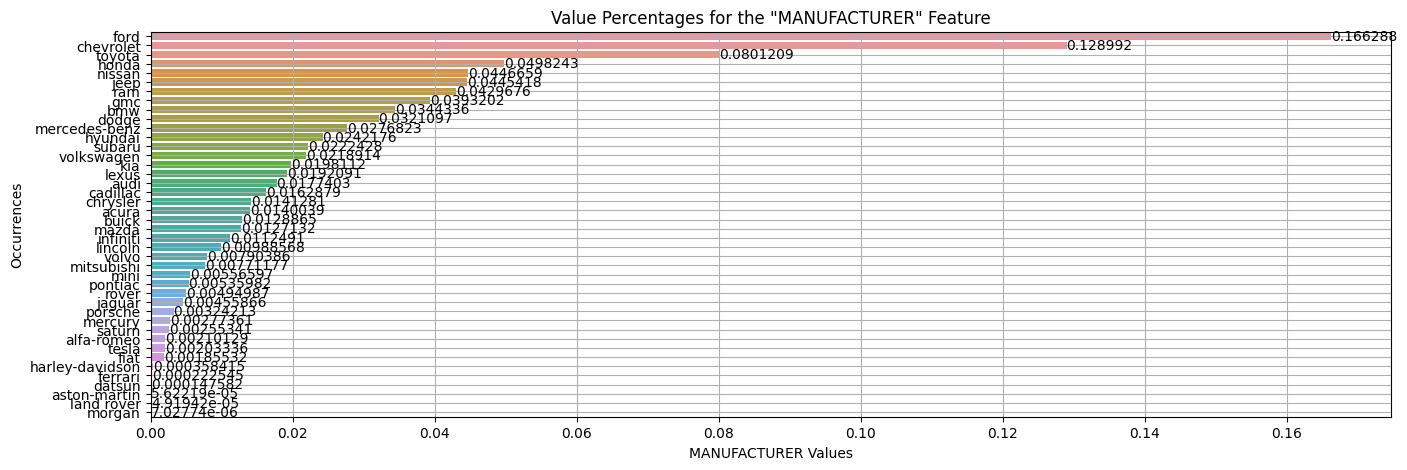


/────────────────────────────────────────────────  FEATURE: CONDITION  ────────────────────────────────────────────────/
 |    | Value     |      Count |
|----+-----------+------------|
|  0 | nan       | 0.407852   |
|  1 | good      | 0.28452    |
|  2 | excellent | 0.237694   |
|  3 | like new  | 0.0496111  |
|  4 | fair      | 0.0158569  |
|  5 | new       | 0.00305707 |
|  6 | salvage   | 0.00140789 |


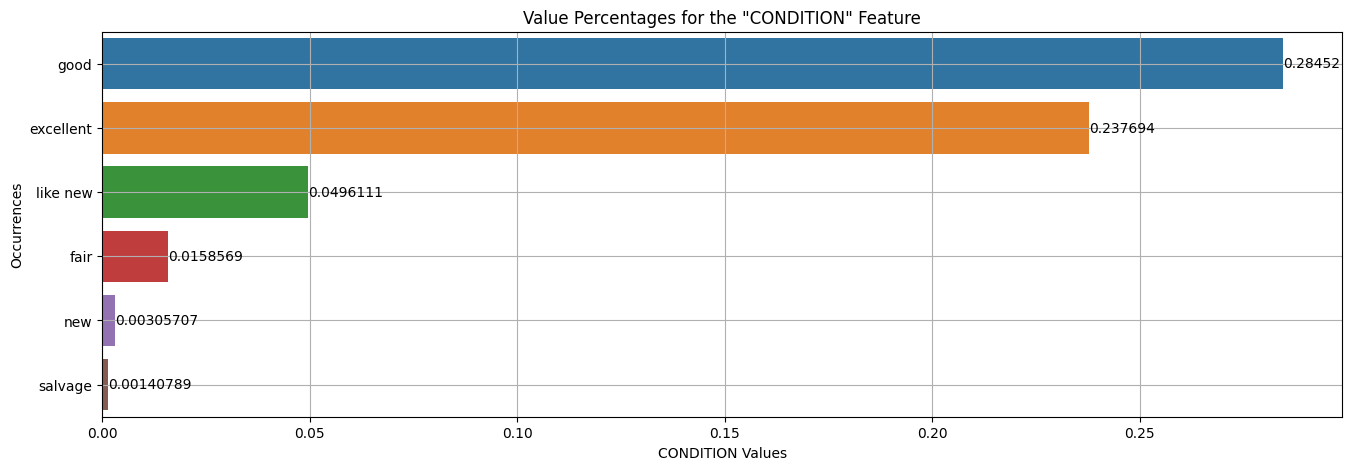


/────────────────────────────────────────────────  FEATURE: CYLINDERS  ────────────────────────────────────────────────/
 |    | Value        |       Count |
|----+--------------+-------------|
|  0 | nan          | 0.416225    |
|  1 | 6 cylinders  | 0.220598    |
|  2 | 4 cylinders  | 0.181882    |
|  3 | 8 cylinders  | 0.168811    |
|  4 | 5 cylinders  | 0.00401049  |
|  5 | 10 cylinders | 0.00340845  |
|  6 | other        | 0.00304067  |
|  7 | 3 cylinders  | 0.00153439  |
|  8 | 12 cylinders | 0.000489599 |


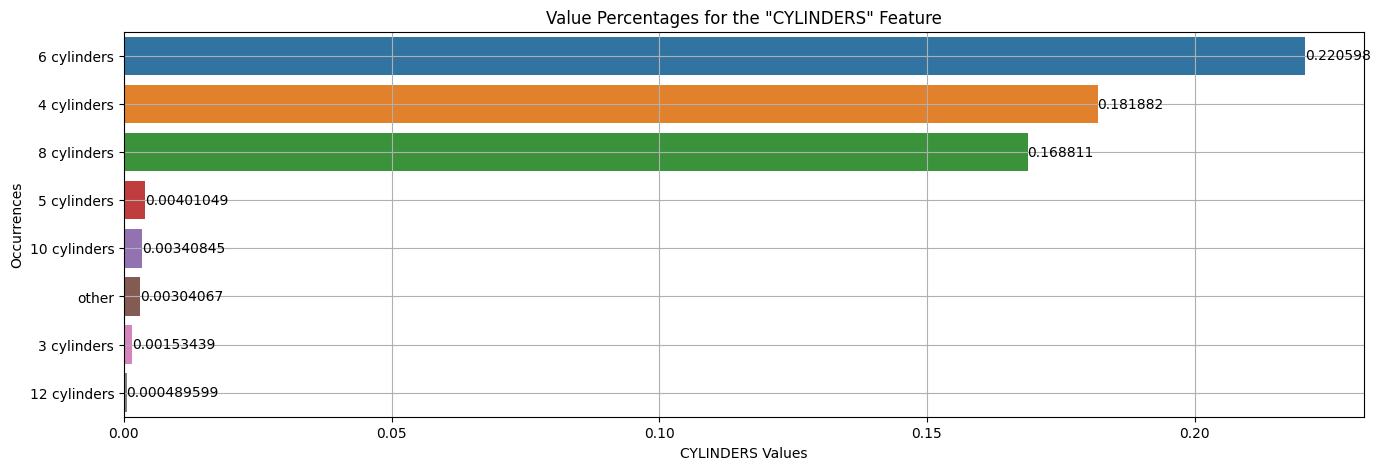


/──────────────────────────────────────────────────  FEATURE: FUEL  ──────────────────────────────────────────────────/
 |    | Value    |      Count |
|----+----------+------------|
|  0 | gas      | 0.834448   |
|  1 | other    | 0.0719828  |
|  2 | diesel   | 0.0704226  |
|  3 | hybrid   | 0.0121111  |
|  4 | nan      | 0.00705819 |
|  5 | electric | 0.0039777  |


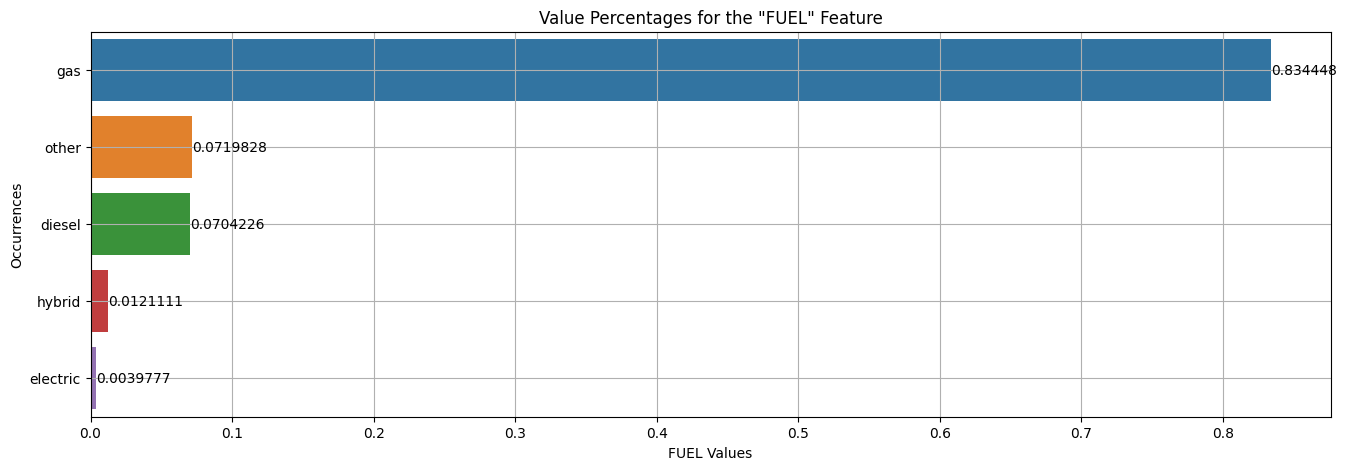


/──────────────────────────────────────────────  FEATURE: TITLE_STATUS  ──────────────────────────────────────────────/
 |    | Value      |       Count |
|----+------------+-------------|
|  0 | clean      | 0.949018    |
|  1 | nan        | 0.0193075   |
|  2 | rebuilt    | 0.0169111   |
|  3 | salvage    | 0.00906109  |
|  4 | lien       | 0.00333115  |
|  5 | missing    | 0.00190686  |
|  6 | parts only | 0.000463831 |


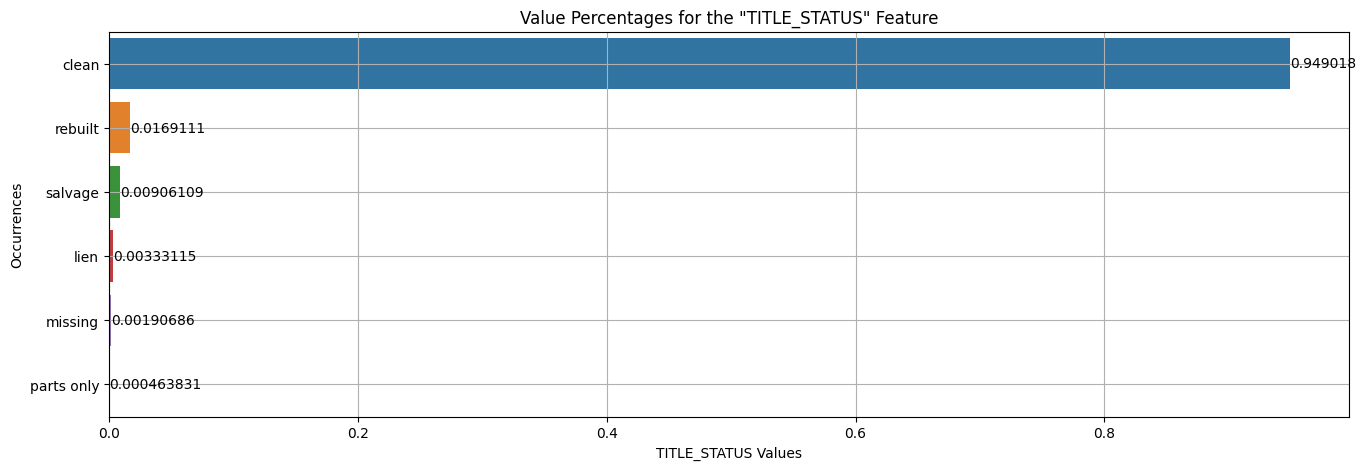


/──────────────────────────────────────────────  FEATURE: TRANSMISSION  ──────────────────────────────────────────────/
 |    | Value     |      Count |
|----+-----------+------------|
|  0 | automatic | 0.788334   |
|  1 | other     | 0.146838   |
|  2 | manual    | 0.0588409  |
|  3 | nan       | 0.00598763 |


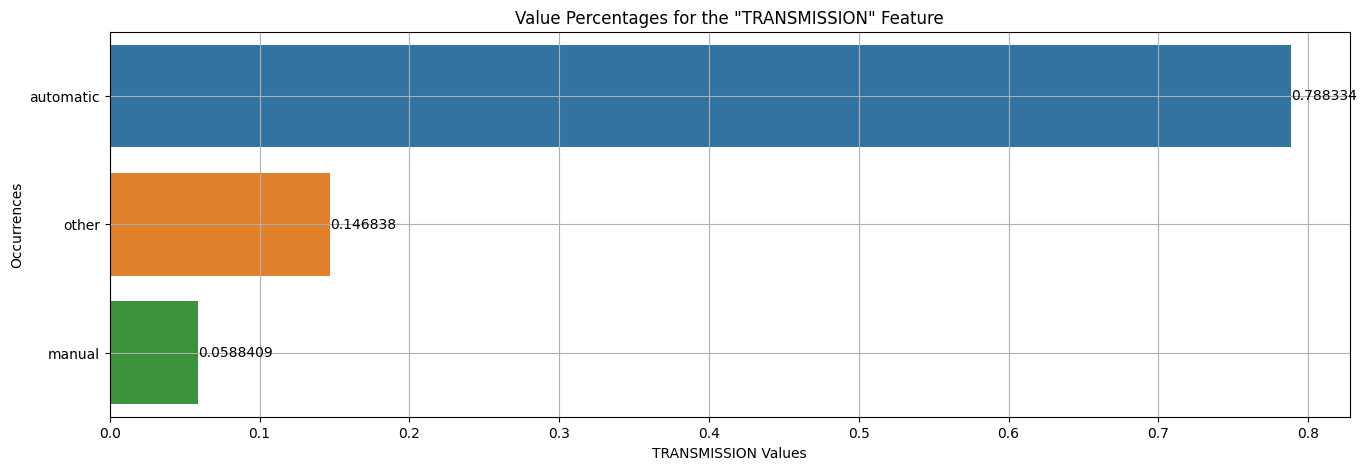


/──────────────────────────────────────────────────  FEATURE: DRIVE  ──────────────────────────────────────────────────/
 |    | Value   |    Count |
|----+---------+----------|
|  0 | 4wd     | 0.308996 |
|  1 | nan     | 0.305863 |
|  2 | fwd     | 0.247182 |
|  3 | rwd     | 0.137959 |


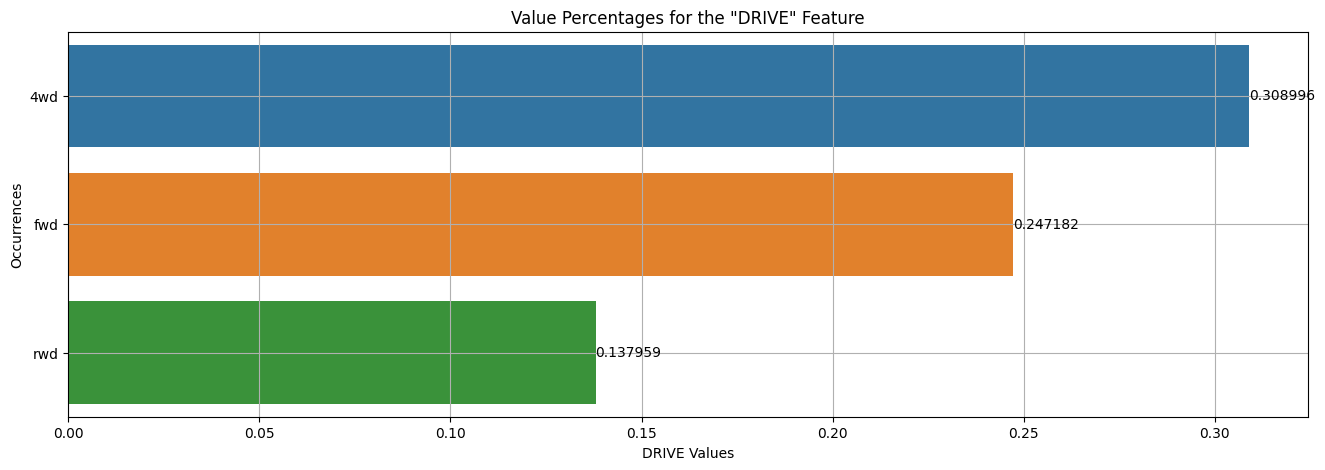


/──────────────────────────────────────────────────  FEATURE: SIZE  ──────────────────────────────────────────────────/
 |    | Value       |     Count |
|----+-------------+-----------|
|  0 | nan         | 0.717675  |
|  1 | full-size   | 0.148672  |
|  2 | mid-size    | 0.0807627 |
|  3 | compact     | 0.0454085 |
|  4 | sub-compact | 0.0074822 |


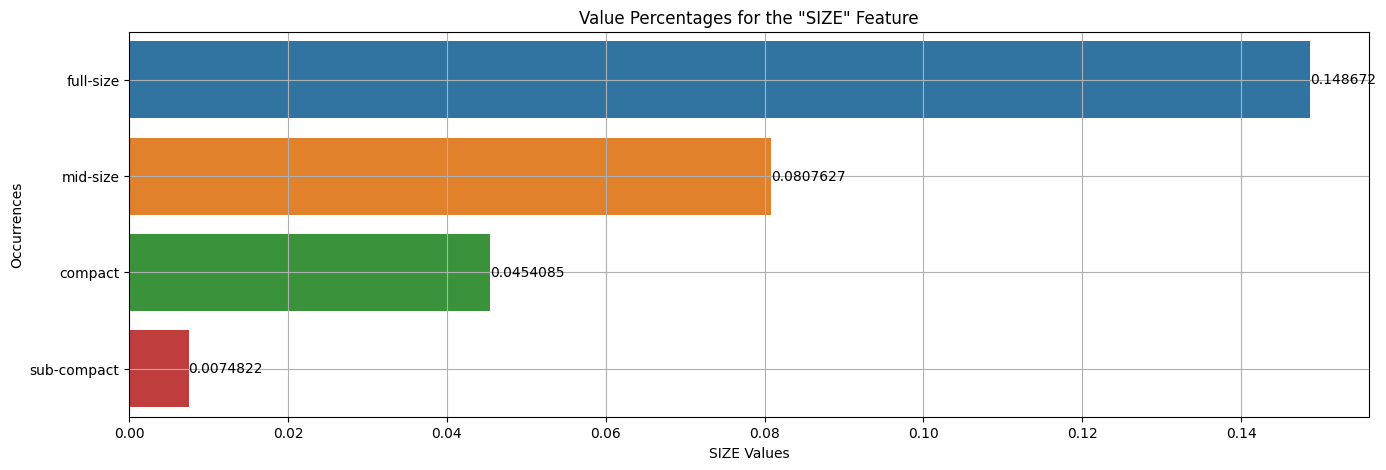


/──────────────────────────────────────────────────  FEATURE: TYPE  ──────────────────────────────────────────────────/
 |    | Value       |      Count |
|----+-------------+------------|
|  0 | nan         | 0.217527   |
|  1 | sedan       | 0.203936   |
|  2 | SUV         | 0.181044   |
|  3 | pickup      | 0.101926   |
|  4 | truck       | 0.0826438  |
|  5 | other       | 0.0517944  |
|  6 | coupe       | 0.0449869  |
|  7 | hatchback   | 0.0388821  |
|  8 | wagon       | 0.0251851  |
|  9 | van         | 0.0200244  |
| 10 | convertible | 0.0181105  |
| 11 | mini-van    | 0.0113029  |
| 12 | offroad     | 0.00142663 |
| 13 | bus         | 0.00121111 |


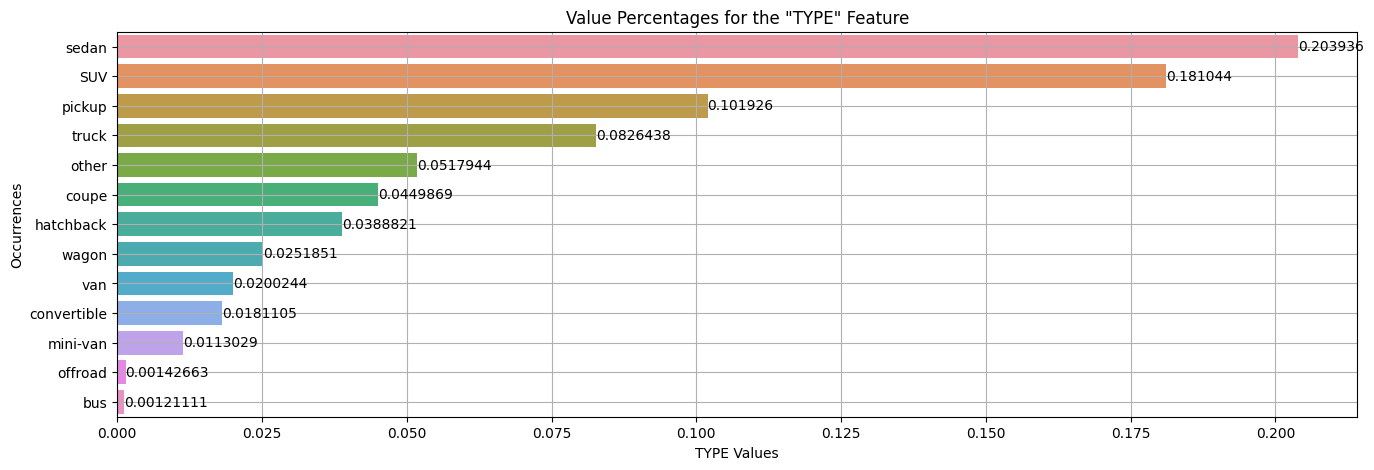


/───────────────────────────────────────────────  FEATURE: PAINT_COLOR  ───────────────────────────────────────────────/
 |    | Value   |      Count |
|----+---------+------------|
|  0 | nan     | 0.305011   |
|  1 | white   | 0.185731   |
|  2 | black   | 0.147257   |
|  3 | silver  | 0.100661   |
|  4 | blue    | 0.0731423  |
|  5 | red     | 0.0713854  |
|  6 | grey    | 0.0571964  |
|  7 | green   | 0.0172016  |
|  8 | custom  | 0.0156953  |
|  9 | brown   | 0.0154446  |
| 10 | yellow  | 0.0050178  |
| 11 | orange  | 0.00464768 |
| 12 | purple  | 0.00160935 |


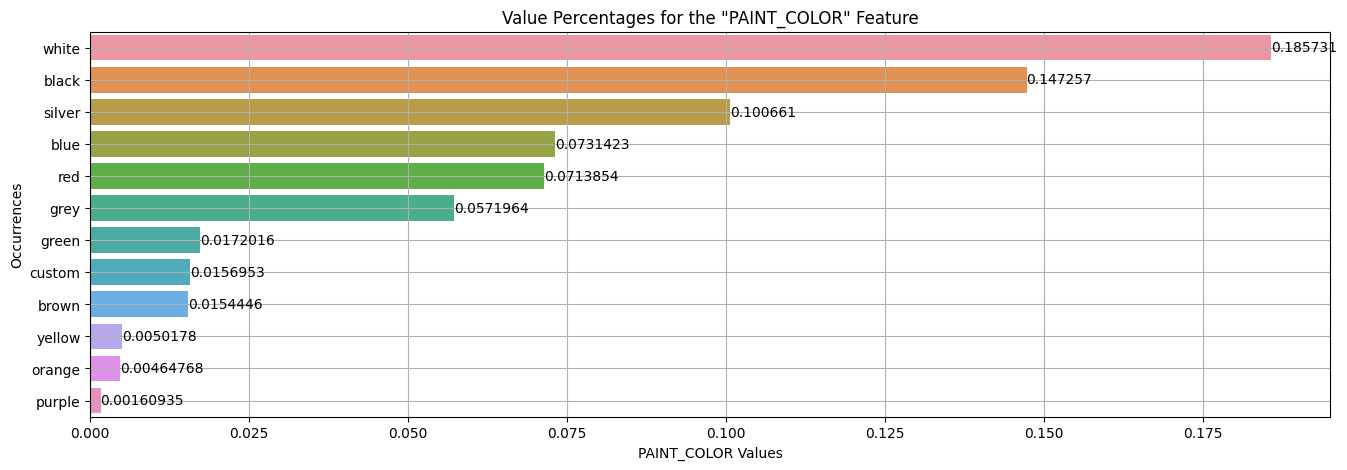

In [16]:

for cmv in cols_categorical:
    df_cmv = pd.DataFrame(df[cmv].value_counts( dropna=False, normalize=True ).sort_values( ascending=False )).reset_index()
    #df_cmv[cmv] = round( df_cmv[cmv] * 100, 3 )
    print( helper_print_heading( f'Feature: {cmv}' ),
           tabulate( df_cmv, headers=["Value", "Count"], tablefmt="orgtbl" )
         )
    ax = sns.barplot( df_cmv, x='proportion', y=cmv, orient='h' )
    ax.bar_label(ax.containers[0])
    plt.title(f'Value Percentages for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Occurrences')
    plt.grid()
    plt.show()
    


/──────────────────────────────────────────────────  FEATURE: PRICE  ──────────────────────────────────────────────────/



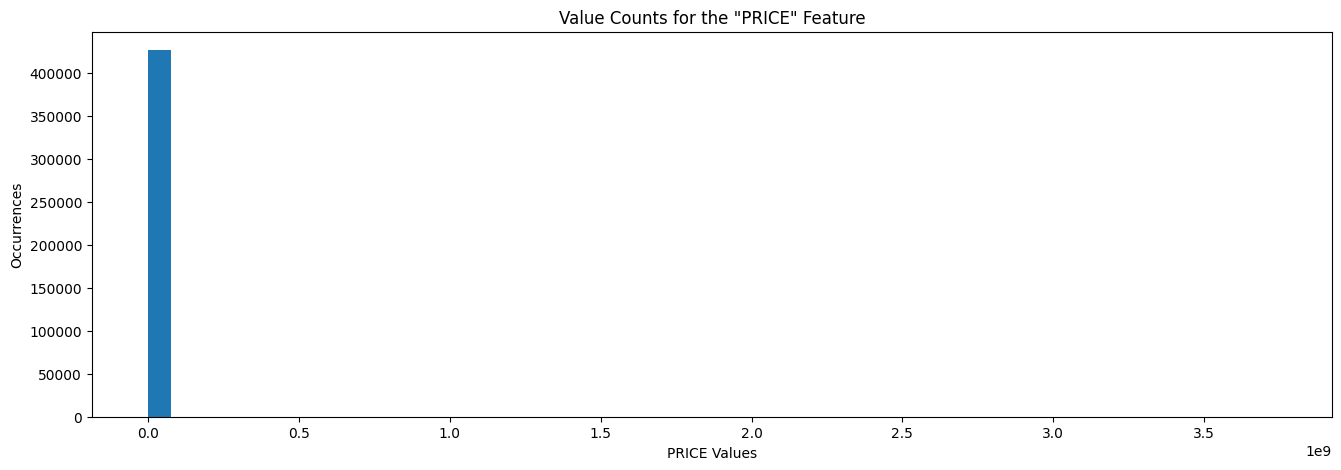


/──────────────────────────────────────────────────  FEATURE: YEAR  ──────────────────────────────────────────────────/



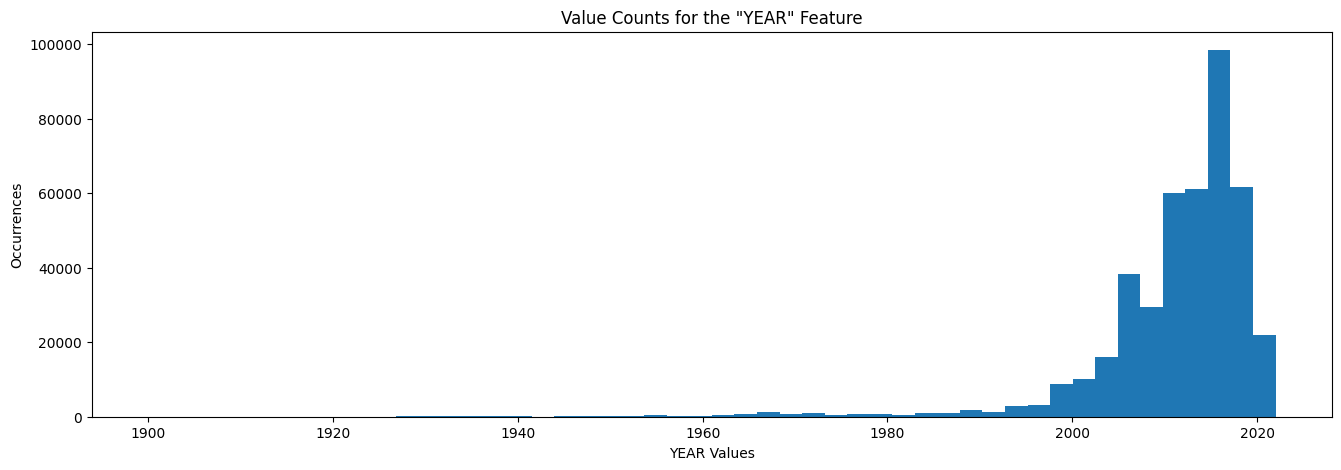


/────────────────────────────────────────────────  FEATURE: ODOMETER  ────────────────────────────────────────────────/



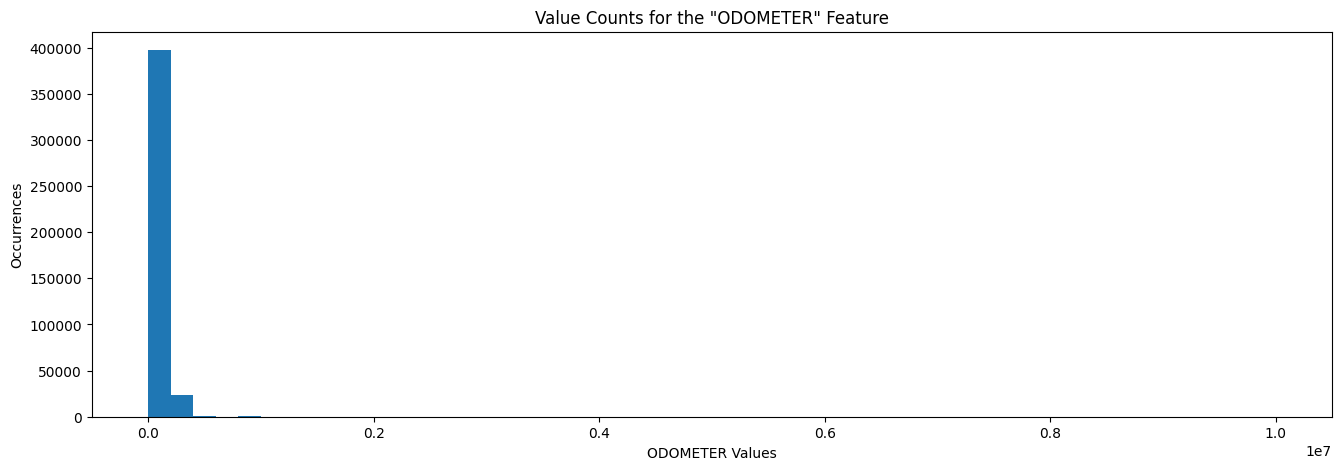

In [17]:
for cmv in cols_numerical:
    print( helper_print_heading( f'Feature: {cmv}' ))
    df[cmv].hist(bins=50)
    plt.title(f'Value Counts for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Occurrences')
    plt.grid()
    plt.show()
    

#### Bivariate Analysis
Explore a pair plot and correlation matrix to understand feature relationships with each other, as well as with the target feature, `price`

In [18]:
#sns.pairplot(df[cols_numerical])

<Axes: >

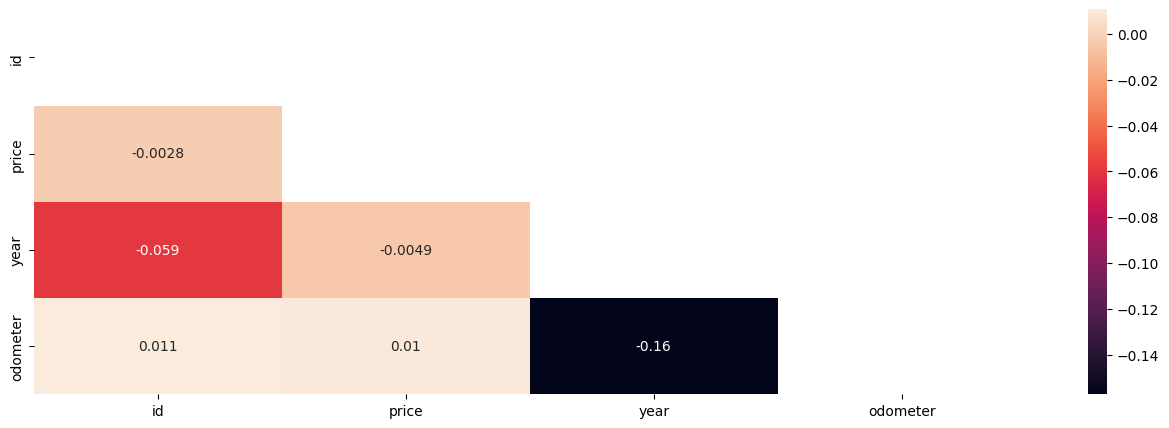

In [19]:
# Heatmap of Correlation coefficients
mask = np.triu(np.ones_like(df.corr(numeric_only=True).round(2)))
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot=True)

# numerical features are not highly correlated

#### Observations and Conclusions

##### Data Integrity:
1. ***Drop records missing more than 9***: `dropna(thresh=10)`
2. ***Drop the `id` and `model` columns***:
    * `id` feature is not valuable for modeling, as it's simply a record identifier
    * `model` feature has over 29k unique values, where it seems a fair amount of variants -- requires heavy sanitization with unclear value thereafter, so dropping the feature for current modeling exercise.
3. ***Drop the `region` and `state` columns***:
    * `VIN` feature's value review hypothesizes that the same specific vehicle may have been listed in multiple locations, and therefore we cannot rely on `region` or `state` columns when modeling as we're not clear on where it sold. 
    * This observation is confirmed by reviewing number of duplicated records when `region` and `state` fields are dropped, and all others remain as-is, queried by `VIN` value (e.g. "3C6JR6DT3KG560649")
4. ***Then drop duplicate records***
    * We drop duplicates with `VIN` feature still present, as it helps to properly qualify similar cars (duplicate records), when region/state are not factors.
5. ***Drop the `VIN` column***:
    * Also dropping `VIN` since by it's definition, it's a unique value, and has 38% of it's values missing
6. ***Replace N/A values with "other" for categorical features***: when reviewing the missing value data by impacted features, it seems more desirable to keep the records intact and introduce an already used category value of "other" for categorical features.

##### Univariate Analysis:
1. Cars manufactured by ***Ford***, ***Chevrolet*** and ***Honda*** were most available for resale, totaling approximately 38% of the total used car market. (`manufacturer`)
2. When car condition was recorded, the vast majority were in either ***good*** or ***excellent*** condition. (`condition`)
3. When the number of cylinders was recorded, ***6-cylinder*** cars were the most common (22%), closely followed by ***4-cylinder*** (18%) and ***8-cylinder*** (17%) cars. (`cylinders`)
4. Cars fueled by *******gas******* were most abundant (83%), as expected, since internal combustion engines have been the primary engine type outside of the past few years. Any recommendations around fuel type will likely evolve as more EV and hybrid vehicles cycle through lease and resale markets in upcoming years. (`fuel`)
5. Almost 95% of all available used cars indicated a ***************clean*************** car title, necessary for smooth transfer of ownership upon purchase. (`title_status`)
6. Unsurprisingly, ***automatic*** transmissions were most common in used cars (79%). (`transmission`)
7. When the drivetrain type was indicated, ***4wd*** used cars were most common (~31%), followed by front-wheel drive (***fwd***, 25%), and then rear-wheel drive (***rwd***, 14%) (`drive`)
8. When car size classes were indicated, ***full-size*** cars were available almost 84% or higher than other vehicle size classes, followed by ***mid-size***, ***compact***, and ***sub-compact***, respectively. (`size`)
9. Aligned with above observations regarding size, drivetrain, and cylinders, when car type was indicated, ***sedans***, ***SUVs*** and ***pickups*** comprised almost 50% of all available cars. (`type`)
10. When car color was indicated, ***white***, ***black,*** and ***silver*** were most common (respectively), representing over 43% of available cars. (`paint_color`)
11. The target feature, the car’s price, contains extreme values, as well as what appear to be artificial values (e.g. $111111) which will impair the model’s ability to properly predict pricing based on the car’s features. (`price`)

##### Bivariate Analysis:
1. When evaluating ***correlations*** between the original numeric variables, no variables seemed to be strongly correlated to another; none of the variables demonstrated multicollinearity.

##### Feature Engineering:
1. For `transmission` feature, simplify values to `automatic` or `not automatic`, as preparation for onehot-encoding.
2. For `title_status` feature, simplify values to `clean` or `not clean`, as preparation for onehot-encoding.
3. For `year` feature, replace it with a new feature called `age`, calculated as age of vehicle as of this analysis, 2023.
4. For `price` feature, create a categorization feature to classify "valid" price from from "unrealistic"
5. For `condition` feature, combine values that seem to be synonyms, e.g. "new" and "excellent"

    

## Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Drop Records with a Threshold of 10 or More Missing Values

In [20]:
df_dropped = df.dropna(thresh=10).copy()
df.shape, df_dropped.shape

((426880, 18), (426124, 18))

### Drop Feature Columns That Will Not Benefit Modeling
* Based on the above understanding, we'll update our dataset to remove `id`, `VIN`, `region`, `state` features.
* While doing so, also drop any duplicated records when `id`, `region` and `state` are not present

In [21]:
# Note: We are not yet dropping `VIN`, since it's useful to more accurately find duplicate records to drop
df_dropped.drop(["id", "region", "state", "model"], axis=1, inplace = True )
df_dropped

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color
27,33590,2014.0000,gmc,good,8 cylinders,gas,57923.0000,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white
28,22590,2010.0000,chevrolet,good,8 cylinders,gas,71229.0000,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue
29,39590,2020.0000,chevrolet,good,8 cylinders,gas,19160.0000,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red
30,30990,2017.0000,toyota,good,8 cylinders,gas,41124.0000,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red
31,15000,2013.0000,ford,excellent,6 cylinders,gas,128000.0000,clean,automatic,NaN,rwd,full-size,truck,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0000,nissan,good,6 cylinders,gas,32226.0000,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN
426876,30590,2020.0000,volvo,good,NaN,gas,12029.0000,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red
426877,34990,2020.0000,cadillac,good,NaN,diesel,4174.0000,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white
426878,28990,2018.0000,lexus,good,6 cylinders,gas,30112.0000,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver


In [22]:
df_dropped.duplicated().sum(), df_dropped.shape

(180788, (426124, 14))

In [23]:
df_dropped.drop_duplicates( inplace = True )
df_dropped.duplicated().sum(), df_dropped.shape

(0, (245336, 14))

In [24]:
df_dropped.drop(["VIN"], axis = 1, inplace = True )
df_dropped

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
27,33590,2014.0000,gmc,good,8 cylinders,gas,57923.0000,clean,other,NaN,NaN,pickup,white
28,22590,2010.0000,chevrolet,good,8 cylinders,gas,71229.0000,clean,other,NaN,NaN,pickup,blue
29,39590,2020.0000,chevrolet,good,8 cylinders,gas,19160.0000,clean,other,NaN,NaN,pickup,red
30,30990,2017.0000,toyota,good,8 cylinders,gas,41124.0000,clean,other,NaN,NaN,pickup,red
31,15000,2013.0000,ford,excellent,6 cylinders,gas,128000.0000,clean,automatic,rwd,full-size,truck,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426833,6800,1997.0000,jaguar,good,8 cylinders,gas,69550.0000,clean,automatic,rwd,compact,convertible,white
426838,21900,1920.0000,NaN,good,6 cylinders,gas,11065.0000,clean,manual,rwd,full-size,other,black
426839,54999,2017.0000,NaN,NaN,NaN,gas,119000.0000,clean,automatic,NaN,NaN,NaN,NaN
426846,41999,2015.0000,NaN,NaN,NaN,gas,126000.0000,clean,automatic,NaN,NaN,NaN,NaN


### Address Missing Values:
Take a somewhat simplistic approach to retain as much data as reasonable for modelling
* Replace categorical missing values with "other"
* Replace numerical missing values with ***mean*** values

In [25]:
# Address NaNs in categorical features
columns_cat_fill = df_dropped.select_dtypes(include=["object"]).columns.tolist()
df_dropped[columns_cat_fill] = df_dropped[columns_cat_fill].fillna( "other" )
df_dropped.isna().sum().sort_values(ascending=False)

odometer        2261
year             644
price              0
manufacturer       0
condition          0
cylinders          0
fuel               0
title_status       0
transmission       0
drive              0
size               0
type               0
paint_color        0
dtype: int64

In [26]:
# Address NaNs in numerical features
df_dropped["year"] = df_dropped["year"].fillna( int(df_dropped["year"].mean()) )
df_dropped["odometer"] = df_dropped["odometer"].fillna( int(df_dropped["odometer"].mean()) )

df_dropped.isna().sum().sort_values(ascending=False)

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64

#### Evalute Target Feature ("price")

In [27]:
df_dropped["price"].describe([.01, .05, .1, .15, .85, .90, .95, .96, .97, .98, .99])

# large number of records are at the extreme values, they may negatively impact predictions; investigate further

count       245336.0000
mean        102185.6062
std       14863585.3176
min              0.0000
1%               0.0000
5%               0.0000
10%            899.0000
15%           2750.0000
50%           9999.0000
85%          26995.0000
90%          32000.0000
95%          39999.0000
96%          43950.0000
97%          47864.9500
98%          53977.0000
99%          64999.0000
max     3736928711.0000
Name: price, dtype: float64

In [28]:
df.sort_values('price', ascending=False).head(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.0000,toyota,tundra,excellent,8 cylinders,gas,164000.0000,clean,automatic,NaN,4wd,full-size,pickup,silver,or
356716,7302445002,knoxville,3736928711,1999.0000,toyota,4runner,fair,6 cylinders,gas,211000.0000,clean,automatic,NaN,4wd,mid-size,NaN,green,tn
257840,7309735768,south jersey,3024942282,2000.0000,mercedes-benz,benz s430,NaN,NaN,gas,100000.0000,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
91576,7309730903,delaware,3024942282,2000.0000,mercedes-benz,benz e320,NaN,NaN,gas,100000.0000,clean,automatic,NaN,NaN,NaN,NaN,NaN,de
37410,7314052904,modesto,3009548743,2021.0000,chevrolet,NaN,NaN,8 cylinders,gas,1000.0000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
184704,7304345156,frederick,1410065407,1989.0000,jeep,wrangler,NaN,NaN,diesel,103000.0000,clean,manual,NaN,NaN,NaN,SUV,NaN,md
153082,7305153975,indianapolis,1234567890,2006.0000,volvo,vnl,fair,NaN,other,200000.0000,clean,manual,NaN,NaN,NaN,NaN,black,in
29386,7305265540,humboldt county,1111111111,1999.0000,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0000,clean,automatic,NaN,rwd,full-size,pickup,white,ca
37409,7314053169,modesto,1111111111,2020.0000,jeep,NaN,NaN,NaN,gas,1000.0000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
122470,7315836487,atlanta,987654321,1960.0000,chevrolet,NaN,NaN,NaN,gas,9999999.0000,clean,manual,NaN,NaN,NaN,NaN,NaN,ga


In [29]:
df_dropped.query('manufacturer == "toyota" and type=="pickup"').sort_values("price", ascending=False)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
318592,3736928711,2007.0000,toyota,excellent,8 cylinders,gas,164000.0000,clean,automatic,4wd,full-size,pickup,silver
131301,63000,2021.0000,toyota,new,8 cylinders,gas,1800.0000,lien,automatic,4wd,other,pickup,grey
77353,63000,2021.0000,toyota,new,8 cylinders,gas,500.0000,lien,automatic,4wd,other,pickup,grey
129312,61999,2020.0000,toyota,other,other,gas,7267.0000,clean,other,4wd,other,pickup,other
130280,59999,2018.0000,toyota,other,other,gas,27893.0000,clean,other,4wd,other,pickup,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51226,0,2016.0000,toyota,good,other,other,17104.0000,clean,automatic,rwd,other,pickup,other
129567,0,2021.0000,toyota,other,other,gas,13899.0000,clean,other,4wd,other,pickup,other
51222,0,2019.0000,toyota,other,other,other,22538.0000,clean,automatic,4wd,other,pickup,other
50001,0,2009.0000,toyota,excellent,6 cylinders,gas,65176.0000,clean,automatic,4wd,mid-size,pickup,white


In [30]:
df_dropped.sort_values('price', ascending=True).head(20)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
90290,0,2014.0000,mercedes-benz,other,8 cylinders,gas,46944.0000,clean,automatic,rwd,full-size,sedan,silver
409199,0,2013.0000,toyota,other,6 cylinders,gas,66579.0000,clean,automatic,4wd,other,other,other
404554,0,2013.0000,ram,other,other,gas,85654.0000,clean,automatic,4wd,other,truck,black
68887,0,2010.0000,infiniti,excellent,other,gas,163000.0000,clean,automatic,other,other,sedan,black
391009,0,2012.0000,ford,other,other,gas,100989.0000,clean,manual,other,sub-compact,hatchback,silver
124049,0,2020.0000,toyota,other,other,gas,21016.0000,clean,automatic,other,other,other,other
17676,0,2017.0000,dodge,good,other,other,75458.0000,clean,automatic,fwd,other,van,other
91683,0,2013.0000,kia,other,other,other,150956.0000,clean,automatic,other,other,other,other
17675,0,2021.0000,jeep,good,other,other,4633.0000,clean,automatic,fwd,other,SUV,white
17673,0,2021.0000,chevrolet,good,other,other,9792.0000,clean,automatic,fwd,other,SUV,black


In [31]:

df_dropped["condition"].value_counts()

condition
other        96967
excellent    69990
good         54523
like new     15742
fair          6499
new           1038
salvage        577
Name: count, dtype: int64

### Feature Engineering

#### Create new features
* Convert `year` to `age` based on current year (2023)
* Simplify values for `transmission` and `title` by keeping the most occurring value, and coalescing all other values into it's "not" value
* Create new `price_eval` feature to understand (and remove) records where the price value seems irregular and may negatively impact the model
* Map synonym values for `condition` to reduce number of unique values

In [32]:
# Create new `age` feature
df_dropped['age'] = 2023 - df_dropped['year']

# Simplify `transmission` to be either the majority value, or not the majority (in this case, "automatic")
df_dropped['transmission_bool'] = df_dropped['transmission'].apply(lambda x: 'automatic' if x == 'automatic' else 'not automatic')

# Simplify `title` to be either the majority value, or not the majority (in this case, "clean")
df_dropped['title_bool'] = df_dropped['title_status'].apply(lambda x: 'clean' if x == 'clean' else 'not clean')

# Create new `price_eval` feature, which is a reflection of checking each records price against the `check_sequence()` custom function
df_dropped["price_eval"] = df['price'].apply( check_sequence )

# Create new `condition_mapped` feature, which reduces the number of unique values by combining synonym values
df_dropped["condition_mapped"] = df_dropped['condition'].apply(lambda x: 'excellent' if x == 'new' else 'good' if x == 'like new' else x )

df_dropped

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,age,transmission_bool,title_bool,price_eval,condition_mapped
27,33590,2014.0000,gmc,good,8 cylinders,gas,57923.0000,clean,other,other,other,pickup,white,9.0000,not automatic,clean,valid,good
28,22590,2010.0000,chevrolet,good,8 cylinders,gas,71229.0000,clean,other,other,other,pickup,blue,13.0000,not automatic,clean,valid,good
29,39590,2020.0000,chevrolet,good,8 cylinders,gas,19160.0000,clean,other,other,other,pickup,red,3.0000,not automatic,clean,valid,good
30,30990,2017.0000,toyota,good,8 cylinders,gas,41124.0000,clean,other,other,other,pickup,red,6.0000,not automatic,clean,valid,good
31,15000,2013.0000,ford,excellent,6 cylinders,gas,128000.0000,clean,automatic,rwd,full-size,truck,black,10.0000,automatic,clean,valid,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426833,6800,1997.0000,jaguar,good,8 cylinders,gas,69550.0000,clean,automatic,rwd,compact,convertible,white,26.0000,automatic,clean,valid,good
426838,21900,1920.0000,other,good,6 cylinders,gas,11065.0000,clean,manual,rwd,full-size,other,black,103.0000,not automatic,clean,valid,good
426839,54999,2017.0000,other,other,other,gas,119000.0000,clean,automatic,other,other,other,other,6.0000,automatic,clean,valid,other
426846,41999,2015.0000,other,other,other,gas,126000.0000,clean,automatic,other,other,other,other,8.0000,automatic,clean,valid,other


#### Drop non-"valid" records for `price`
* Drop any records where the `price_eval` is not "valid"

***This is a test, may be tuned once model results are reviewed***



In [33]:
# check how many records are flagged as non-valid price values based on the rules of the custom function `check_sequence()`
df_dropped["price_eval"].value_counts()

price_eval
valid              225478
low                 18575
repeating            1046
sequence (asc)        186
sequence (desc)        39
high                   12
Name: count, dtype: int64

In [34]:
# Query to only slice records with prices that seem "valid", to model
#df_cleaned = df_dropped.query("price_eval == 'valid'").copy()
df_cleaned = df_dropped.query("price > 0").copy()


print( f"\n\nOriginal Dataset Shape: {original_shape}" ) 
print( f"Cleaned Dataset Shape: {df_cleaned.shape}" )
print( f"Percentage of Original Data Preserved: {round(df_cleaned.shape[0] / original_shape[0] * 100, 1)}%\n\n" )

df_cleaned.head()



Original Dataset Shape: (426880, 18)
Cleaned Dataset Shape: (228249, 18)
Percentage of Original Data Preserved: 53.5%




,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,age,transmission_bool,title_bool,price_eval,condition_mapped
27,33590,2014.0000,gmc,good,8 cylinders,gas,57923.0000,clean,other,other,other,pickup,white,9.0000,not automatic,clean,valid,good
28,22590,2010.0000,chevrolet,good,8 cylinders,gas,71229.0000,clean,other,other,other,pickup,blue,13.0000,not automatic,clean,valid,good
29,39590,2020.0000,chevrolet,good,8 cylinders,gas,19160.0000,clean,other,other,other,pickup,red,3.0000,not automatic,clean,valid,good
30,30990,2017.0000,toyota,good,8 cylinders,gas,41124.0000,clean,other,other,other,pickup,red,6.0000,not automatic,clean,valid,good
31,15000,2013.0000,ford,excellent,6 cylinders,gas,128000.0000,clean,automatic,rwd,full-size,truck,black,10.0000,automatic,clean,valid,excellent


In [35]:
df_cleaned = df_cleaned.astype({
    'age': 'int64',
    'odometer': 'int64',
    'year': 'int64'
})
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228249 entries, 27 to 426873
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              228249 non-null  int64 
 1   year               228249 non-null  int64 
 2   manufacturer       228249 non-null  object
 3   condition          228249 non-null  object
 4   cylinders          228249 non-null  object
 5   fuel               228249 non-null  object
 6   odometer           228249 non-null  int64 
 7   title_status       228249 non-null  object
 8   transmission       228249 non-null  object
 9   drive              228249 non-null  object
 10  size               228249 non-null  object
 11  type               228249 non-null  object
 12  paint_color        228249 non-null  object
 13  age                228249 non-null  int64 
 14  transmission_bool  228249 non-null  object
 15  title_bool         228249 non-null  object
 16  price_eval         22824

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

---
### Models to test
* LinearRegression
* Ridge
* Lasso
---

### Create Train/Test datasets
* Training and Test/Validation sets will be created from the entire dataset to establish model scoring/accuracy. 
* The features used to sanitize and engineer new features will be dropped.

In [36]:
# Segment Variable and Target sets
X = df_cleaned.drop(['price', 'year', 'transmission', 'title_status', 'condition'], axis=1)
y = np.log( df_cleaned[['price']] )


In [37]:
# Create lists of numerical and categorical features
# -- Consider: `condition` for Ordinal Encoding based on it's "scale" value set instead of binarizing it

clean_cols_num = X.select_dtypes(exclude=['object']).columns
clean_cols_cat = X.select_dtypes(include=['object']).columns
clean_cols_num, clean_cols_cat

(Index(['odometer', 'age'], dtype='object'),
 Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
        'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
        'condition_mapped'],
       dtype='object'))

In [38]:
# splitting at 80/20 in this case
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((182599, 13), (45650, 13), (182599, 1), (45650, 1))

### Scale and Transform Features
Use OneHot-Encoding to transform the following categorical features into new binary/numerical features:
* `transmission_bool`
* `title_bool`
* `paint_color`
* `type`
* `drive`
* `fuel`
* `condition_mapped`
* `manufacturer`

Use Polynomial transformation (`degree=3`) and Scale for numerical features
* `odometer`
* `age`


In [39]:
# Design the Model, using:
# - Column transformers
# - Standardization

# Setup column transformations; ALL tested models will use these transformations:

poly_scaler_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( include_bias=False )),
    ( 'scale', StandardScaler() )
])

col_transformer = ColumnTransformer(transformers=(
    ( 'poly', poly_scaler_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# GridSearchCV params that are shared between models
gs_degrees = [ 1, 2, 3 ]
gs_alphas = [ 1, 5, 10, 20, 100 ]


### Setup Linear Regression Model
* Create a pipeline that transforms and scales the data, and uses Linear Regression model as the estimator
* Use GridSearch to optimize the `degree` hyperparameter for the polynomial tranformation

In [40]:
# Setup the pipeline for the estimator (Linear Regression)
lr_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', LinearRegression())
])

lr_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', LinearRegression())])

In [41]:
# GridSearch setup for hyperparameter optimization to identify best estimator
lr_params = {
    'transform__poly__pf__degree': gs_degrees
}

lr_grid = GridSearchCV (
    estimator = lr_pipe,
    param_grid = lr_params,
    scoring = 'neg_mean_squared_error',
    cv=5, 
    #verbose = 3, 
    n_jobs = -1, 
    return_train_score=True
)
lr_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['odometer', 'age'], dtype='object')),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                                       ('reg', LinearRegression())]),
             n_jobs=-1, param_grid={'transform__poly__pf__degree': [1, 2, 3]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
# fit the grid model
lr_grid.fit ( X_train, y_train )

# access the best model returned from the grid search
lr_best_model = lr_grid.best_estimator_
lr_best_model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', LinearRegression())])

### Setup Rigde Regularization Model
* Create a pipeline that transforms and scales the data, and uses Ridge Regularization model as the estimator
* Use GridSearch to optimize `degree` and `alpha` hyperparameters for the polynomial tranformation and model, respectively

In [43]:
# Setup the pipeline for the estimator (Ridge)
ridge_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', Ridge( alpha = 1 ))
])

ridge_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', Ridge(alpha=1))])

In [44]:
# GridSearch setup for hyperparameter optimization to identify best estimator
ridge_params = {
    'reg__alpha': gs_alphas,
    'transform__poly__pf__degree': gs_degrees
}

ridge_grid = GridSearchCV (
    estimator = ridge_pipe,
    param_grid = ridge_params,
    scoring = 'neg_mean_squared_error',
    cv=5, 
    #verbose = 3, 
    # n_jobs = 5, 
    return_train_score=True 
)
ridge_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['odometer', 'age'], dtype='object')),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                                       ('reg', Ridge(alpha=1))]),
             param_grid={'reg__alpha': [1, 5, 10, 20, 100],
                         'transform__poly__pf__degree': [1, 2, 3]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
# fit the grid model
ridge_grid.fit ( X_train, y_train );

# access the best model returned from the grid search
ridge_best_model = ridge_grid.best_estimator_
ridge_best_model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', Ridge(alpha=1))])

In [46]:
#ridge_best_model.named_steps

### Setup Lasso Regularization Model
* Create a pipeline that transforms and scales the data, and uses Lasso Regularization model as the estimator
* Use GridSearch to optimize `degree` and `alpha` hyperparameters for the polynomial tranformation and model, respectively

In [47]:
# Setup the pipeline for the estimator (Lasso)
lasso_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', Lasso( alpha = 1 ))
])

lasso_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', Lasso(alpha=1))])

In [48]:
# GridSearch setup for hyperparameter optimization to identify best estimator
lasso_params = {
    'reg__alpha': gs_alphas,
    'transform__poly__pf__degree': gs_degrees
}

lasso_grid = GridSearchCV (
    estimator = lasso_pipe,
    param_grid = lasso_params,
    scoring = 'neg_mean_squared_error',
    cv=10, 
    #verbose = 3, 
    # n_jobs = 5, 
    return_train_score=True
)
lasso_grid


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['odometer', 'age'], dtype='object')),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                                       ('reg', Lasso(alpha=1))]),
             param_grid={'reg__alpha': [1, 5, 10, 20, 100],
                         'transform__poly__pf__degree': [1, 2, 3]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [49]:
# fit the grid model
lasso_grid.fit ( X_train, y_train )

# access the best model returned from the grid search
lasso_best_model = lasso_grid.best_estimator_
lasso_best_model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['odometer', 'age'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
       'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
       'condition_mapped'],
      dtype='object'))))),
                ('reg', Lasso(alpha=1))])

In [50]:
lasso_best_model.named_steps

{'transform': ColumnTransformer(transformers=(('poly',
                                  Pipeline(steps=[('pf',
                                                   PolynomialFeatures(degree=1,
                                                                      include_bias=False)),
                                                  ('scale', StandardScaler())]),
                                  Index(['odometer', 'age'], dtype='object')),
                                 ('ohe',
                                  OneHotEncoder(drop='if_binary',
                                                sparse_output=False),
                                  Index(['manufacturer', 'cylinders', 'fuel', 'drive', 'size', 'type',
        'paint_color', 'transmission_bool', 'title_bool', 'price_eval',
        'condition_mapped'],
       dtype='object')))),
 'reg': Lasso(alpha=1)}

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [51]:
# Setup dataframes to aggregate model comparison information
error_df = pd.DataFrame( columns=["Model", "Best Parameters", "MSE Train", "MSE Test", "Model Score"] )


---
### Collate Evaluation Metrics From the Best Estimator for Each Tested Model:
* Best hyperparameters 
* MSE errors for both Train and Test datasets
* Best model score
---
#### Linear Regression

In [52]:
lr_grid.best_params_

{'transform__poly__pf__degree': 3}

In [53]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
lr_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=lr_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

lr_transformer = ColumnTransformer(transformers=(
    ( 'poly', lr_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# Fit and transform training and test values to map against predicted
pred_x_train_lr = lr_transformer.fit_transform( X_train )
pred_x_test_lr = lr_transformer.transform( X_test )

# Evaluate loss and scoring
lr_mse_train = mean_squared_error ( lr_best_model.named_steps["reg"].predict ( pred_x_train_lr ), y_train )
lr_mse_test = mean_squared_error ( lr_best_model.named_steps["reg"].predict ( pred_x_test_lr ), y_test )
lr_score = lr_grid.best_score_
lr_hyperparameters = f"Degree: {lr_grid.best_params_['transform__poly__pf__degree']:.3f}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Linear Regression' ))
print( f"Best Degree: {lr_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Training MSE: {lr_mse_train:.3f}" )
print( f"Test MSE: {lr_mse_test:.3f}" )
print( f"Best Score: {lr_score:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Linear Regression', 
                           lr_hyperparameters, 
                           round(lr_mse_train, 3), 
                           round(lr_mse_test, 3), 
                           round(lr_score, 3) 
             ]



/─────────────────────────────────────────────  MODEL: LINEAR REGRESSION  ─────────────────────────────────────────────/

Best Degree: 3.000
Training MSE: 0.590
Test MSE: 0.593
Best Score: -0.591


#### Ridge Regularization

In [54]:
ridge_grid.best_params_

{'reg__alpha': 1, 'transform__poly__pf__degree': 3}

In [55]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
ridge_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=ridge_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

ridge_transformer = ColumnTransformer(transformers=(
    ( 'poly', ridge_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# Fit and transform training and test values to map against predicted
pred_x_train_ridge = ridge_transformer.fit_transform( X_train )
pred_x_test_ridge = ridge_transformer.transform( X_test )

# Evaluate loss and scoring
ridge_mse_train = mean_squared_error ( ridge_best_model.named_steps["reg"].predict ( pred_x_train_ridge ), y_train )
ridge_mse_test = mean_squared_error ( ridge_best_model.named_steps["reg"].predict ( pred_x_test_ridge ), y_test )
ridge_score = ridge_grid.best_score_
ridge_hyperparameters = f"Degree: {ridge_grid.best_params_['transform__poly__pf__degree']:.3f}, Alpha: {ridge_grid.best_params_['reg__alpha']:.3f}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Ridge Regularization' ))
print( f"Best Degree: {ridge_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Best Alpha: {ridge_grid.best_params_['reg__alpha']:.3f}" )
print( f"Training MSE: {ridge_mse_train:.3f}" )
print( f"Test MSE: {ridge_mse_test:.3f}" )
print( f"Best Score: {ridge_score:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Ridge Regularization', 
                           ridge_hyperparameters, 
                           round(ridge_mse_train, 3), 
                           round(ridge_mse_test, 3), 
                           round(ridge_score, 3) 
             ]


/───────────────────────────────────────────  MODEL: RIDGE REGULARIZATION  ───────────────────────────────────────────/

Best Degree: 3.000
Best Alpha: 1.000
Training MSE: 0.590
Test MSE: 0.593
Best Score: -0.591


#### Lasso Regularization

In [56]:
lasso_grid.best_params_

{'reg__alpha': 1, 'transform__poly__pf__degree': 1}

In [57]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
lasso_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=lasso_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

lasso_transformer = ColumnTransformer(transformers=(
    ( 'poly', lasso_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# Fit and transform training and test values to map against predicted
pred_x_train_lasso = lasso_transformer.fit_transform( X_train )
pred_x_test_lasso = lasso_transformer.transform( X_test )

# Evaluate loss and scoring
lasso_mse_train = mean_squared_error ( lasso_best_model.named_steps["reg"].predict ( pred_x_train_lasso ), y_train )
lasso_mse_test = mean_squared_error ( lasso_best_model.named_steps["reg"].predict ( pred_x_test_lasso ), y_test )
lasso_score = lasso_grid.best_score_
lasso_hyperparameters = f"Degree: {lasso_grid.best_params_['transform__poly__pf__degree']:.3f} , Alpha: {lasso_grid.best_params_['reg__alpha']:.3f}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Lasso Regularization' ))
print( f"Best Degree: {lasso_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Best Alpha: {lasso_grid.best_params_['reg__alpha']:.3f}" )
print( f"Training MSE: {lasso_mse_train:.3f}" )
print( f"Test MSE: {lasso_mse_test:.3f}" )
print( f"Best Score: {lasso_score:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Lasso Regularization', 
                           lasso_hyperparameters, 
                           round(lasso_mse_train, 3), 
                           round(lasso_mse_test, 3), 
                           round(lasso_score, 3) 
             ]


/───────────────────────────────────────────  MODEL: LASSO REGULARIZATION  ───────────────────────────────────────────/

Best Degree: 1.000
Best Alpha: 1.000
Training MSE: 1.466
Test MSE: 1.436
Best Score: -1.466


In [58]:
# Compare Error and Scoring metrics between models
error_df

,Model,Best Parameters,MSE Train,MSE Test,Model Score
0,Linear Regression,Degree: 3.000,0.5900,0.5930,-0.5910
1,Ridge Regularization,"Degree: 3.000, Alpha: 1.000",0.5900,0.5930,-0.5910
2,Lasso Regularization,"Degree: 1.000 , Alpha: 1.000",1.4660,1.4360,-1.4660


### Compare Cross-Validation Results By Model

In [59]:
cv_lr = pd.DataFrame( lr_grid.cv_results_ ).sort_values('rank_test_score')
cv_lr


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,1.2934,0.0435,0.0785,0.0054,3,{'transform__poly__pf__degree': 3},-0.5951,-0.5740,-0.5771,-0.6143,...,-0.5912,0.0146,1,-0.5887,-0.5940,-0.5930,-0.5838,-0.5884,-0.5896,0.0037
1,1.9539,0.0463,0.0916,0.0018,2,{'transform__poly__pf__degree': 2},-0.6282,-0.6060,-0.6101,-0.6484,...,-0.6240,0.0151,2,-0.6212,-0.6268,-0.6257,-0.6162,-0.6214,-0.6223,0.0038
0,1.8683,0.0319,0.1006,0.0051,1,{'transform__poly__pf__degree': 1},-0.7632,-0.7462,-0.7513,-0.7783,...,-0.7615,0.0116,3,-0.7595,-0.7638,-0.7624,-0.7556,-0.7579,-0.7599,0.0030


In [60]:
cv_ridge = pd.DataFrame( ridge_grid.cv_results_ ).sort_values('rank_test_score')
cv_ridge


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.5690,0.0365,0.1660,0.0360,1,3,"{'reg__alpha': 1, 'transform__poly__pf__degree...",-0.5954,-0.5745,-0.5769,...,-0.5912,0.0144,1,-0.5886,-0.5939,-0.5930,-0.5838,-0.5884,-0.5896,0.0036
5,0.6969,0.0303,0.1342,0.0241,5,3,"{'reg__alpha': 5, 'transform__poly__pf__degree...",-0.5971,-0.5772,-0.5774,...,-0.5922,0.0139,2,-0.5895,-0.5948,-0.5941,-0.5848,-0.5894,-0.5905,0.0036
8,0.6231,0.0565,0.1381,0.0253,10,3,"{'reg__alpha': 10, 'transform__poly__pf__degre...",-0.5989,-0.5801,-0.5788,...,-0.5936,0.0133,3,-0.5908,-0.5961,-0.5955,-0.5863,-0.5909,-0.5919,0.0036
11,0.5510,0.0456,0.1354,0.0271,20,3,"{'reg__alpha': 20, 'transform__poly__pf__degre...",-0.6015,-0.5840,-0.5811,...,-0.5957,0.0127,4,-0.5929,-0.5979,-0.5978,-0.5886,-0.5934,-0.5941,0.0035
14,0.6499,0.0385,0.1427,0.0118,100,3,"{'reg__alpha': 100, 'transform__poly__pf__degr...",-0.6109,-0.5943,-0.5897,...,-0.6037,0.0116,5,-0.6009,-0.6051,-0.6060,-0.5975,-0.6027,-0.6025,0.0030
1,0.6883,0.1068,0.1425,0.0092,1,2,"{'reg__alpha': 1, 'transform__poly__pf__degree...",-0.6286,-0.6065,-0.6098,...,-0.6240,0.0150,6,-0.6212,-0.6268,-0.6257,-0.6162,-0.6214,-0.6223,0.0038
4,0.4947,0.0533,0.1155,0.0253,5,2,"{'reg__alpha': 5, 'transform__poly__pf__degree...",-0.6302,-0.6093,-0.6103,...,-0.6250,0.0144,7,-0.6221,-0.6278,-0.6268,-0.6172,-0.6224,-0.6232,0.0038
7,0.6549,0.0820,0.1321,0.0245,10,2,"{'reg__alpha': 10, 'transform__poly__pf__degre...",-0.6320,-0.6122,-0.6116,...,-0.6263,0.0139,8,-0.6234,-0.6290,-0.6282,-0.6187,-0.6238,-0.6246,0.0037
10,0.5881,0.0943,0.1286,0.0141,20,2,"{'reg__alpha': 20, 'transform__poly__pf__degre...",-0.6346,-0.6161,-0.6138,...,-0.6284,0.0132,9,-0.6254,-0.6308,-0.6305,-0.6210,-0.6263,-0.6268,0.0036
13,0.5581,0.0767,0.1283,0.0288,100,2,"{'reg__alpha': 100, 'transform__poly__pf__degr...",-0.6427,-0.6258,-0.6218,...,-0.6357,0.0121,10,-0.6328,-0.6372,-0.6379,-0.6292,-0.6349,-0.6344,0.0032


In [61]:
cv_lasso = pd.DataFrame( lasso_grid.cv_results_ ).sort_values('rank_test_score')
cv_lasso


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.4793,0.0178,0.0608,0.0121,1,1,"{'reg__alpha': 1, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
1,0.4961,0.0207,0.0566,0.0076,1,2,"{'reg__alpha': 1, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
2,0.5021,0.0253,0.0575,0.0077,1,3,"{'reg__alpha': 1, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
3,0.4867,0.0197,0.0619,0.0076,5,1,"{'reg__alpha': 5, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
4,0.4907,0.0115,0.0564,0.0130,5,2,"{'reg__alpha': 5, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
5,0.5040,0.0325,0.0591,0.0102,5,3,"{'reg__alpha': 5, 'transform__poly__pf__degree...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
6,0.4853,0.0214,0.0617,0.0045,10,1,"{'reg__alpha': 10, 'transform__poly__pf__degre...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
7,0.4889,0.0234,0.0647,0.0106,10,2,"{'reg__alpha': 10, 'transform__poly__pf__degre...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
8,0.5037,0.0194,0.0644,0.0086,10,3,"{'reg__alpha': 10, 'transform__poly__pf__degre...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039
9,0.5036,0.0264,0.0656,0.0153,20,1,"{'reg__alpha': 20, 'transform__poly__pf__degre...",-1.5012,-1.4732,-1.4260,...,-1.4700,-1.4697,-1.4714,-1.4658,-1.4638,-1.4590,-1.4681,-1.4617,-1.4656,0.0039


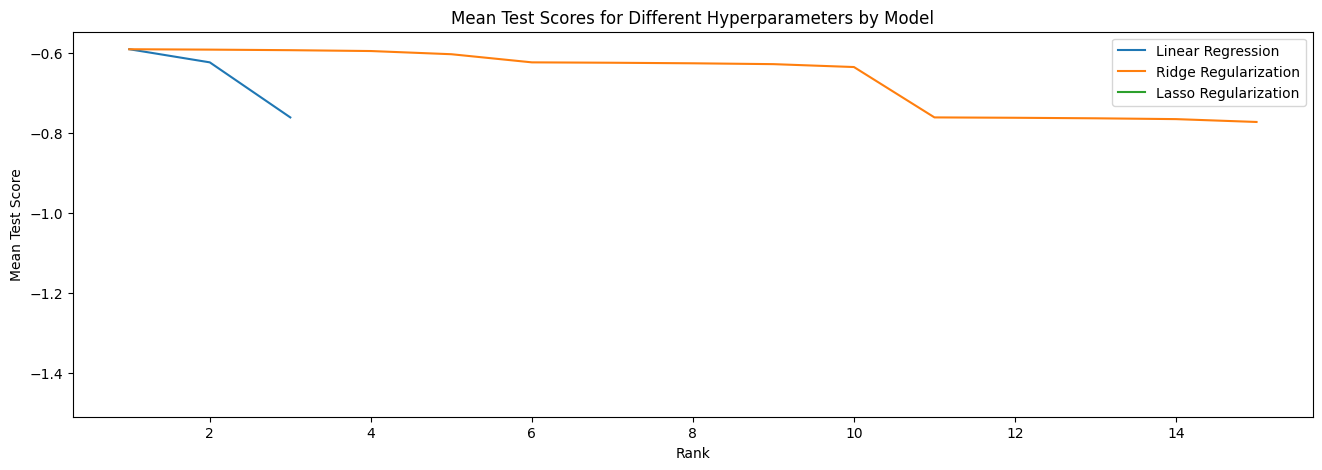

In [62]:
# Visualize the best model's alpha values vs. MSE

plt.plot(cv_lr['rank_test_score'],cv_lr['mean_test_score'], label = 'Linear Regression')
plt.plot(cv_ridge['rank_test_score'],cv_ridge['mean_test_score'], label = 'Ridge Regularization')
plt.plot(cv_lasso['rank_test_score'],cv_lasso['mean_test_score'], label = 'Lasso Regularization')

plt.ylabel('Mean Test Score')
plt.xlabel('Rank')
plt.title("Mean Test Scores for Different Hyperparameters by Model")
plt.legend()
plt.show()


### Review Best Coefficients for Each Model

In [63]:
# Linear Regression coefs
coefs_lr = [lr_best_model.named_steps["reg"].coef_]
coefs_lr_cols = lr_best_model.named_steps["transform"].get_feature_names_out()

coefs_lr_df = pd.DataFrame ( coefs_lr[0], columns = coefs_lr_cols ).T
coefs_lr_df.rename(columns={0:"coefs"}, inplace = True)
coefs_lr_df["coefs"] = round( coefs_lr_df["coefs"], 2 )
coefs_lr_df["abs_coefs"] = abs( coefs_lr_df["coefs"] )

coefs_lr_df.sort_values( "abs_coefs", ascending=False ).head( 10 )


,coefs,abs_coefs
ohe__condition_mapped_excellent,215691295802.6100,215691295802.6100
ohe__condition_mapped_other,215691295802.4900,215691295802.4900
ohe__condition_mapped_good,215691295802.4500,215691295802.4500
ohe__condition_mapped_fair,215691295801.6800,215691295801.6800
ohe__condition_mapped_salvage,215691295801.4700,215691295801.4700
ohe__paint_color_other,-43208739113.1800,43208739113.1800
ohe__paint_color_green,-43208739112.9400,43208739112.9400
ohe__paint_color_brown,-43208739112.9000,43208739112.9000
ohe__paint_color_blue,-43208739112.8900,43208739112.8900
ohe__paint_color_silver,-43208739112.8900,43208739112.8900


In [64]:
# Ridge Regularization coefs
coefs_ridge = [ridge_best_model.named_steps["reg"].coef_]
coefs_ridge_cols = ridge_best_model.named_steps["transform"].get_feature_names_out()

coefs_ridge_df = pd.DataFrame ( coefs_ridge[0], columns = coefs_ridge_cols ).T
coefs_ridge_df.rename(columns={0:"coefs"}, inplace = True)
coefs_ridge_df["coefs"] = round( coefs_ridge_df["coefs"], 2 )
coefs_ridge_df["abs_coefs"] = abs( coefs_ridge_df["coefs"] )

coefs_ridge_df.sort_values( "abs_coefs", ascending=False ).head( 20 )

,coefs,abs_coefs
ohe__price_eval_high,9.9500,9.9500
ohe__price_eval_low,-7.6600,7.6600
poly__age^2,2.4700,2.4700
ohe__price_eval_sequence (desc),-1.7200,1.7200
poly__age,-1.6600,1.6600
ohe__manufacturer_ferrari,1.5700,1.5700
poly__odometer^2,1.2800,1.2800
poly__age^3,-1.1100,1.1100
poly__odometer^3,-0.8400,0.8400
ohe__manufacturer_morgan,-0.8300,0.8300


In [65]:
# Lasso Regularization coefs
coefs_lasso = [lasso_best_model.named_steps["reg"].coef_]
coefs_lasso_cols = lasso_best_model.named_steps["transform"].get_feature_names_out().tolist()

coefs_lasso_df = pd.DataFrame ( coefs_lasso, columns = coefs_lasso_cols ).T
coefs_lasso_df.rename(columns={0:"coefs"}, inplace = True)
coefs_lasso_df["coefs"] = round( coefs_lasso_df["coefs"], 2 )
coefs_lasso_df["abs_coefs"] =  abs( coefs_lasso_df["coefs"] )

coefs_lasso_df.query("abs_coefs > 0.0").sort_values( "abs_coefs", ascending=False )


,coefs,abs_coefs


## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.